In [12]:
import numpy as np
import scipy as sp
import mne
from os import listdir
from os.path import join
import pandas as pd
import sklearn
import re
import pickle
from tqdm.notebook import tqdm
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from neuromancer import utils

from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import mne
import pandas as pd
from os import listdir, path

TASK_LIST = ['facecat/female','facecat/male',
             'facecat/nosmile', 'facecat/smiles',
             'facecat/old', 'facecat/young',
            'facecat/blond', 'facecat/darkhaired']

# Load Results and Latents

In [13]:
with open(f"results/lda_classifier.obj", 'rb') as file:
        results = pickle.load(file)
        
with open(f"../data/EEG_New/latents/latents.pkl", 'rb') as file:
        latents = pickle.load(file)

In [14]:
results[0]['facecat/female'].keys()

dict_keys(['yhat', 'y', 'img_id', 'event'])

# Show a quick plot of the ROC AUC Scores

In [15]:
roc_scores = []
for i in range(30):
    for task in TASK_LIST:
        roc_scores.append(sklearn.metrics.roc_auc_score(results[i][task]['y'],results[i][task]['yhat'], average="macro", multi_class='ovo'))

(array([ 2.,  0.,  2.,  2.,  3.,  3.,  4.,  8.,  5., 12., 13., 19., 10.,
        15., 22., 17., 19., 14., 16., 10., 17., 15.,  4.,  5.,  3.]),
 array([0.54984663, 0.56600901, 0.58217139, 0.59833377, 0.61449616,
        0.63065854, 0.64682092, 0.66298331, 0.67914569, 0.69530807,
        0.71147045, 0.72763284, 0.74379522, 0.7599576 , 0.77611999,
        0.79228237, 0.80844475, 0.82460713, 0.84076952, 0.8569319 ,
        0.87309428, 0.88925667, 0.90541905, 0.92158143, 0.93774381,
        0.9539062 ]),
 <BarContainer object of 25 artists>)

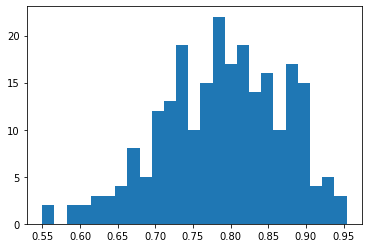

In [16]:
plt.hist(roc_scores, bins=25)

# Create Results Dataframe

In [17]:
yhats = []
latent_list = []
img_ids = []
task_name = [] 
user_id = []
events = []

for user in range(30):
    for task in TASK_LIST:
        yhats.extend(list(results[user][task]['yhat']))
        img_ids.extend(results[user][task]['img_id'])
        events.extend(results[user][task]['event'])
        for i in range(len(list(results[user][task]['yhat']))):
            task_name.append(task)
            user_id.append(user)

# Fix img_ids
img_ids_fixed = []
for img_id in img_ids:
    img_ids_fixed.append(int(img_id))
    
img_ids = img_ids_fixed
del img_ids_fixed

# Now get all the latents
for img_id in img_ids:
    try:
        latent_list.append(np.array(latents.loc[int(img_id)]))
    except:
        latent_list.append(None)
        
        
df = pd.DataFrame.from_dict({'yhat': yhats, 
                             'latent': latent_list,
                             'img_id': img_ids,
                             'task': task_name,
                             'user_id': user_id,
                             'event':events})
df = df.dropna()
        

# Linear Interpolation Function

In [18]:
def linear_interpolate(latent_code,
                       boundary,
                       start_distance=-5.0,
                       end_distance=5.0,
                       steps=20):
  """Manipulates the given latent code with respect to a particular boundary.
  Basically, this function takes a latent code and a boundary as inputs, and
  outputs a collection of manipulated latent codes. For example, let `steps` to
  be 10, then the input `latent_code` is with shape [1, latent_space_dim], input
  `boundary` is with shape [1, latent_space_dim] and unit norm, the output is
  with shape [10, latent_space_dim]. The first output latent code is
  `start_distance` away from the given `boundary`, while the last output latent
  code is `end_distance` away from the given `boundary`. Remaining latent codes
  are linearly interpolated.
  Input `latent_code` can also be with shape [1, num_layers, latent_space_dim]
  to support W+ space in Style GAN. In this case, all features in W+ space will
  be manipulated same as each other. Accordingly, the output will be with shape
  [10, num_layers, latent_space_dim].
  NOTE: Distance is sign sensitive.
  Args:
    latent_code: The input latent code for manipulation.
    boundary: The semantic boundary as reference.
    start_distance: The distance to the boundary where the manipulation starts.
      (default: -3.0)
    end_distance: The distance to the boundary where the manipulation ends.
      (default: 3.0)
    steps: Number of steps to move the latent code from start position to end
      position. (default: 10)
  """
  linspace = np.linspace(start_distance, end_distance, steps)
    
  if len(latent_code.shape) == 2:
    linspace = linspace - latent_code.dot(boundary.T)
    linspace = linspace.reshape(-1, 1).astype(np.float32)
    return latent_code + linspace * boundary
  if len(latent_code.shape) == 3:
    linspace = linspace.reshape(-1, 1, 1).astype(np.float32)
    return latent_code + linspace * boundary.reshape(1, 1, -1)
  raise ValueError(f'Input `latent_code` should be with shape '
                   f'[1, latent_space_dim] or [1, N, latent_space_dim] for '
                   f'W+ space in Style GAN!\n'
                   f'But {latent_code.shape} is received.')

In [19]:
np.mean(df[df.event==201])

yhat                                                0.528211
latent     [0.025953516925033993, 0.0055679030466451165, ...
img_id                                               56410.3
user_id                                              14.5064
event                                                    201
dtype: object

In [20]:
# Img_ID, Task, User_ID, Event mapping
mappings = df.copy()
mappings = mappings.drop(['yhat', 'latent'], axis=1)

with open(f"results/stimuli_mapping.obj", 'wb') as file:
    pickle.dump(df, file)

In [24]:
# Completely Random Process to modify latents
# For each user
# For each task
# Train SVM using Leave-One-Out
from sklearn.model_selection import train_test_split
from sklearn import svm

In [25]:
latents

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
3645,-0.102176,-0.341570,-0.190693,1.539568,-0.779896,-1.900885,-0.189544,-0.169174,0.260766,0.424599,...,1.339004,0.207651,-0.433295,0.041304,0.377524,1.401116,0.462393,-0.223615,-0.764296,-0.330194
254,1.190803,0.699312,-0.512271,-0.376671,2.111981,-0.565978,2.314016,-0.514498,-0.695664,0.673128,...,-1.405552,-0.261992,-1.092216,-0.577483,1.342700,-0.493590,0.688819,-0.078695,0.162666,1.570422
3647,1.530188,0.407933,0.023624,1.584645,0.295383,-1.779489,-1.337683,1.623311,-0.018364,-0.977433,...,0.605085,-0.620042,0.898587,-0.544203,0.387235,0.569479,1.717202,0.849760,0.726146,-0.362230
3650,0.554931,-0.790965,0.145018,0.168000,-0.756989,-1.008559,-0.048545,-0.567280,-1.374936,0.262423,...,1.032234,1.070753,-1.246692,0.490732,1.837290,-0.051366,0.067696,-0.439227,2.952573,0.112598
255,0.351926,0.890074,-1.168892,1.102292,-1.726503,0.099458,0.044104,0.993282,-1.179480,-1.373889,...,1.345792,-1.017283,-0.474380,-0.756631,1.297887,-0.803970,0.370798,-0.640366,1.564543,-1.929542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12076,0.819076,-0.661894,-1.330911,1.262312,0.135800,-0.011355,0.050273,0.734981,-0.030662,1.243162,...,1.790809,1.172088,0.572908,0.884027,-2.648886,0.096305,-0.396920,-1.625164,-0.516191,0.440730
57487,-0.788750,-0.909465,2.011715,1.715507,-0.111300,-0.393713,1.253555,-0.558190,-1.449670,0.913913,...,-0.403179,0.000393,-1.549657,-0.315365,0.819237,-0.963366,1.016520,-0.323531,0.302397,0.696981
49485,-0.000054,-0.314698,-0.009371,-0.398899,-0.663481,0.578298,-1.346476,-1.198353,-1.041210,1.235691,...,-1.713272,-1.278225,0.261003,-0.760522,-0.000794,-0.557934,-2.106686,-0.962155,-0.831790,0.277722
90023,-0.516268,-0.480062,-2.123539,-1.033846,-0.260287,0.342904,1.262752,1.710058,-1.447566,0.470502,...,-0.316864,-0.291799,1.028444,-1.241929,-0.847020,-0.967035,1.023538,2.503926,-0.139241,-0.702003


In [52]:
def produce_random_array(factor=60):
    i = 0
    random_noise_array = []
    while i<512:
        random_noise_array.append(random.gauss(0, 1))
        i += 1
    return np.array(random_noise_array).reshape((1, 512))/factor

In [ ]:
results_dict = {}
STEPS = 9
for USER in tqdm(range(30)):
    results_dict[USER] = {}
    for TASK in TASK_LIST:
        results_dict[USER][TASK] = {}
        df_subset = df[(df['task']==TASK)&(df['user_id']==USER)]
        for IMG_ID in tqdm(np.unique(df_subset.img_id), leave=False):
            results_dict[USER][TASK][IMG_ID] = {}
            results_dict[USER][TASK][IMG_ID]["POS"] = []
            results_dict[USER][TASK][IMG_ID]["NEG"] = []
            
            train = df_subset[df_subset.img_id!=IMG_ID]
            test = df_subset[df_subset.img_id==IMG_ID]
            
            latent_code = test.reset_index().latent[0].reshape(1,512)
            modification = produce_random_array(STEPS)
            
            results_dict[USER][TASK][IMG_ID]["POS"].append(latent_code)
            results_dict[USER][TASK][IMG_ID]["NEG"].append(latent_code)
            

            #classifier_score = 0
            latent_pick = 0
            
            while latent_pick < STEPS:
                results_dict[USER][TASK][IMG_ID]["POS"].append(latent_code + (modification * latent_pick))
                latent_pick +=1
                
            latent_pick = 0
            
            while latent_pick < STEPS:
                results_dict[USER][TASK][IMG_ID]["NEG"].append(latent_code - (modification * latent_pick))
                latent_pick +=1              

In [54]:
with open(f"results/random_gaussian.obj", 'wb') as file:
    pickle.dump(results_dict, file)

In [49]:
import random
i = 0
random_noise_array = []
while i<512:
    random_noise_array.append(random.gauss(0, 1))
    i += 1
random_noise_array = np.array(random_noise_array).reshape((1, 512))

(1, 512)

# SVR Classification, Leave-One-Out

In [20]:
# For each user
# For each task
# Train SVM using Leave-One-Out
from sklearn.model_selection import train_test_split
from sklearn import svm

In [11]:
results_diinterpolated_latent_direction_neg.shapect = {}
for USER in tqdm(range(30)):
    results_dict[USER] = {}
    for TASK in TASK_LIST:
        results_dict[USER][TASK] = {}
        df_subset = df[(df['task']==TASK)&(df['user_id']==USER)]
        for IMG_ID in tqdm(np.unique(df_subset.img_id), leave=False):
            results_dict[USER][TASK][IMG_ID] = {}
            results_dict[USER][TASK][IMG_ID]["POS"] = []
            results_dict[USER][TASK][IMG_ID]["NEG"] = []
            
            train = df_subset[df_subset.img_id!=IMG_ID]
            test = df_subset[df_subset.img_id==IMG_ID]
            threshold_pos = np.mean(df_subset[df_subset.event==201].yhat) + 2*np.std(df_subset[df_subset.event==201].yhat)
            threshold_neg = np.mean(df_subset[df_subset.event==202].yhat) - 2*np.std(df_subset[df_subset.event==201].yhat)
             
            clf = svm.SVR(kernel='linear')
            classifier = clf.fit(list(train.latent), y=list(train.yhat))
            a = classifier.coef_.reshape(1, 512).astype(np.float32)
            norm_classifier = a / np.linalg.norm(a)
            
            interpolated_latent_direction_pos = linear_interpolate(latent_code=test.reset_index().latent[0].reshape(1,512), 
                                         boundary=norm_classifier, 
                                         start_distance=0, 
                                         end_distance=20, steps=60)

            interpolated_latent_direction_neg = linear_interpolate(latent_code=test.reset_index().latent[0].reshape(1,512), 
                             boundary=norm_classifier, 
                             start_distance=0, 
                             end_distance=-20, steps=60)
            
            results_dict[USER][TASK][IMG_ID]["POS"].append(test.reset_index().latent[0].reshape(1,512))
            results_dict[USER][TASK][IMG_ID]["NEG"].append(test.reset_index().latent[0].reshape(1,512))

            
            classifier_score = 0
            latent_pick = 0
            
            while (classifier_score < threshold_pos) and (latent_pick < 60):
                classifier_score = classifier.predict(interpolated_latent_direction_pos[latent_pick].reshape(1,512))
                results_dict[USER][TASK][IMG_ID]["POS"].append(interpolated_latent_direction_pos[latent_pick])
                latent_pick +=1
                
            classifier_score = 1
            latent_pick = 0
            
            while (classifier_score > threshold_neg) and (latent_pick < 60):
                classifier_score = classifier.predict(interpolated_latent_direction_neg[latent_pick].reshape(1,512))
                results_dict[USER][TASK][IMG_ID]["NEG"].append(interpolated_latent_direction_neg[latent_pick])
                latent_pick +=1                
                
            

In [12]:
with open(f"results/svr_latentsV4.obj", 'wb') as file:
    pickle.dump(results_dict, file)

# Random Classifier

In [21]:
# For each user
# For each task
# Train SVM using Leave-One-Out
from sklearn.model_selection import train_test_split
from sklearn import svm

In [30]:
results_dict = {}
for USER in tqdm(range(30)):
    results_dict[USER] = {}
    for TASK in TASK_LIST:
        results_dict[USER][TASK] = {}
        df_subset = df[(df['task']==TASK)&(df['user_id']==USER)]
        for IMG_ID in tqdm(np.unique(df_subset.img_id), leave=False):
            results_dict[USER][TASK][IMG_ID] = {}
            results_dict[USER][TASK][IMG_ID]["POS"] = []
            results_dict[USER][TASK][IMG_ID]["NEG"] = []
            
            train = df_subset[df_subset.img_id!=IMG_ID]
            test = df_subset[df_subset.img_id==IMG_ID]
            threshold_pos = np.mean(df_subset[df_subset.event==201].yhat) + 2*np.std(df_subset[df_subset.event==201].yhat)
            threshold_neg = np.mean(df_subset[df_subset.event==202].yhat) - 2*np.std(df_subset[df_subset.event==201].yhat)
            
            yhats = list(train.yhat)
            np.random.shuffle(yhats)
            clf = svm.SVR(kernel='linear')
            classifier = clf.fit(list(train.latent), y=yhats)
            a = classifier.coef_.reshape(1, 512).astype(np.float32)
            norm_classifier = a / np.linalg.norm(a)
            
            interpolated_latent_direction_pos = linear_interpolate(latent_code=test.reset_index().latent[0].reshape(1,512), 
                                         boundary=norm_classifier, 
                                         start_distance=0, 
                                         end_distance=20, steps=60)

            interpolated_latent_direction_neg = linear_interpolate(latent_code=test.reset_index().latent[0].reshape(1,512), 
                             boundary=norm_classifier, 
                             start_distance=0, 
                             end_distance=-20, steps=60)
            
            results_dict[USER][TASK][IMG_ID]["POS"].append(test.reset_index().latent[0].reshape(1,512))
            results_dict[USER][TASK][IMG_ID]["NEG"].append(test.reset_index().latent[0].reshape(1,512))

            
            classifier_score = 0
            latent_pick = 0
            
            while (classifier_score < threshold_pos) and (latent_pick < 60):
                classifier_score = classifier.predict(interpolated_latent_direction_pos[latent_pick].reshape(1,512))
                results_dict[USER][TASK][IMG_ID]["POS"].append(interpolated_latent_direction_pos[latent_pick])
                latent_pick +=1
                
            classifier_score = 1
            latent_pick = 0
            
            while (classifier_score > threshold_neg) and (latent_pick < 60):
                classifier_score = classifier.predict(interpolated_latent_direction_neg[latent_pick].reshape(1,512))
                results_dict[USER][TASK][IMG_ID]["NEG"].append(interpolated_latent_direction_neg[latent_pick])
                latent_pick +=1                
                
            

In [31]:
with open(f"results/svr_latents_Random.obj", 'wb') as file:
    pickle.dump(results_dict, file)

# Explicit Classifier

In [10]:
# For each user
# For each task
# Train SVM using Leave-One-Out
from sklearn.model_selection import train_test_split
from sklearn import svm

In [13]:
results_dict = {}
event_from = [201, 202]
event_to = [1.0, 0.0]

for USER in tqdm(range(30)):
    results_dict[USER] = {}
    for TASK in TASK_LIST:
        results_dict[USER][TASK] = {}
        df_subset = df[(df['task']==TASK)&(df['user_id']==USER)]
        for IMG_ID in tqdm(np.unique(df_subset.img_id), leave=False):
            results_dict[USER][TASK][IMG_ID] = {}
            results_dict[USER][TASK][IMG_ID]["POS"] = []
            results_dict[USER][TASK][IMG_ID]["NEG"] = []
            
            train = df_subset[df_subset.img_id!=IMG_ID]
            test = df_subset[df_subset.img_id==IMG_ID]
            threshold_pos = np.mean(df_subset[df_subset.event==201].yhat) + 2*np.std(df_subset[df_subset.event==201].yhat)
            threshold_neg = np.mean(df_subset[df_subset.event==202].yhat) - 2*np.std(df_subset[df_subset.event==201].yhat)
            
            yhats = train.event.map(dict(zip(event_from, event_to)))
            clf = svm.SVR(kernel='linear')
            classifier = clf.fit(list(train.latent), y=yhats)
            a = classifier.coef_.reshape(1, 512).astype(np.float32)
            norm_classifier = a / np.linalg.norm(a)
            
            interpolated_latent_direction_pos = linear_interpolate(latent_code=test.reset_index().latent[0].reshape(1,512), 
                                         boundary=norm_classifier, 
                                         start_distance=0, 
                                         end_distance=20, steps=60)

            interpolated_latent_direction_neg = linear_interpolate(latent_code=test.reset_index().latent[0].reshape(1,512), 
                             boundary=norm_classifier, 
                             start_distance=0, 
                             end_distance=-20, steps=60)
            
            results_dict[USER][TASK][IMG_ID]["POS"].append(test.reset_index().latent[0].reshape(1,512))
            results_dict[USER][TASK][IMG_ID]["NEG"].append(test.reset_index().latent[0].reshape(1,512))

            
            classifier_score = 0
            latent_pick = 0
            
            while (classifier_score < threshold_pos) and (latent_pick < 60):
                classifier_score = classifier.predict(interpolated_latent_direction_pos[latent_pick].reshape(1,512))
                results_dict[USER][TASK][IMG_ID]["POS"].append(interpolated_latent_direction_pos[latent_pick])
                latent_pick +=1
                
            classifier_score = 1
            latent_pick = 0
            
            while (classifier_score > threshold_neg) and (latent_pick < 60):
                classifier_score = classifier.predict(interpolated_latent_direction_neg[latent_pick].reshape(1,512))
                results_dict[USER][TASK][IMG_ID]["NEG"].append(interpolated_latent_direction_neg[latent_pick])
                latent_pick +=1                
                
            

In [14]:
with open(f"results/svr_latents_Explicit.obj", 'wb') as file:
    pickle.dump(results_dict, file)